# Running FEISTY with time-series forcing from CESM

Kristen produced a 1 degree companion run to our high-res run on frontera, and then converted output to time series.
This notebook doesn't really need to be a notebook, I'm hoping it can be converted to a script instead.
All the parameter settings are handled in the first (non-`import`) cell, where we read in `feisty-config.TL319_g17.4p2z.001.yml`.
This was run on a casper compute node with 50 GB of memory
(the `.compute()` uses a lot of memory on this node, and the `map_da_back_to_2D_pop()` effectively doubles it).
This run actually used all 50 GB, so more might be needed.

## Imports

In [1]:
import os

import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml
from dask.distributed import Client
from dask_jobqueue import PBSCluster

import feisty

/glade/work/mlevy/miniconda3/envs/dev-feisty/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Configure run

The FEISTY command `config_and_run_from_yaml()` needs a dictionary pointing to forcing streams and initial conditions.
We provide a few `YAML` files containing acceptable configurations.
There are also several parameters controlling how the run is set up.

In [2]:
# Read settings from YAML
feisty_config_file = 'feisty-config.TL319_g17.4p2z.001.yml'
with open(feisty_config_file) as f:
    feisty_config = yaml.safe_load(f)

In [3]:
print(f'Configuring FEISTY... this is lazy, so ds_out.compute() is needed for computation')

# map_blocks lets us run in parallel over our dask cluster
ds_out = feisty.config_and_run_from_yaml(feisty_config)
ds_out["biomass"]

Configuring FEISTY... this is lazy, so ds_out.compute() is needed for computation
Starting template generation at 11:33:38


<xarray.DataArray 'biomass' (time: 3650, group: 9, X: 86096)>
dask.array<biomass-config_and_run_from_dataset, shape=(3650, 9, 86096), dtype=float64, chunksize=(3650, 9, 4784), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1958-01-01 00:00:00 ... 1967-12-31 00:00:00
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * X        (X) MultiIndex
  - nlat     (X) int64 2 2 2 2 2 2 2 3 3 ... 382 382 382 382 382 382 382 382 382
  - nlon     (X) int64 0 1 2 208 209 210 211 0 1 ... 68 69 86 87 270 271 272 273

## Set up Dask cluster

Since the data in `ds` is chunked in `X`, we use a `dask` cluster to configure the parallelization

In [4]:
mem = 20  # GB
dask.config.set({'distributed.dashboard.link': 'proxy/{port}/status'})
# dask.config.set({"distributed.comm.timeouts.tcp": "180s"})
# dask.config.set({"distributed.comm.timeouts.connect": "180s"})
cluster = PBSCluster(
    memory=f'{mem} GB',
    processes=1,
    cores=1,
    queue='casper',
    walltime='1:00:00',
    resource_spec=f'select=1:ncpus=1:mem={mem}GB',
    log_directory='./dask-logs',
)

cluster.scale(feisty_config['num_chunks'])
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: proxy/8787/status,
Dashboard: proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.58:33129,Workers: 0
Dashboard: proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Run the model

In [5]:
%%time
print(f'Configuring and running FEISTY...')
da_out = ds_out["biomass"].compute()

da_out

Configuring and running FEISTY...
CPU times: user 11.9 s, sys: 29.1 s, total: 41 s
Wall time: 3min 19s


<xarray.DataArray 'biomass' (time: 3650, group: 9, X: 86096)>
array([[[9.99980761e-06, 9.99980748e-06, 9.99980731e-06, ...,
         9.99981084e-06, 9.99981084e-06, 9.99981084e-06],
        [9.99915919e-06, 9.99915820e-06, 9.99915693e-06, ...,
         9.99918447e-06, 9.99918449e-06, 9.99918450e-06],
        [9.99915919e-06, 9.99915820e-06, 9.99915693e-06, ...,
         9.99918447e-06, 9.99918449e-06, 9.99918450e-06],
        ...,
        [1.00519498e-05, 1.00520196e-05, 1.00521098e-05, ...,
         1.00501517e-05, 1.00501504e-05, 1.00501496e-05],
        [9.98052113e-06, 9.98052143e-06, 9.98052184e-06, ...,
         9.98048576e-06, 9.98048584e-06, 9.98048591e-06],
        [2.32378249e-03, 2.34797373e-03, 2.36020475e-03, ...,
         2.00331343e-03, 2.00331720e-03, 2.00331951e-03]],

       [[9.99964134e-06, 9.99964115e-06, 9.99964091e-06, ...,
         9.99964612e-06, 9.99964612e-06, 9.99964613e-06],
        [9.99831845e-06, 9.99831647e-06, 9.99831392e-06, ...,
         9.99836901e-06, 9.99836904e-06, 9.99836907e-06],
        [9.99831845e-06, 9.99831647e-06, 9.99831392e-06, ...,
         9.99836901e-06, 9.99836904e-06, 9.99836907e-06],
...
        [4.85293386e-04, 4.70085177e-04, 4.66988577e-04, ...,
         2.23767866e-03, 2.23798258e-03, 2.24035367e-03],
        [3.84436081e-04, 4.12847741e-04, 4.88123579e-04, ...,
         6.80401024e-03, 6.89510589e-03, 7.00661483e-03],
        [2.94035106e-01, 3.07414029e-01, 3.35862245e-01, ...,
         1.08040727e+00, 1.09001700e+00, 1.10591078e+00]],

       [[5.14220519e-05, 5.05445542e-05, 5.06622377e-05, ...,
         6.11524873e-04, 6.12044396e-04, 6.13168612e-04],
        [6.96823435e-07, 6.68866164e-07, 6.66099431e-07, ...,
         7.26625598e-06, 7.26984058e-06, 7.27108558e-06],
        [1.10747322e-06, 1.15052282e-06, 1.32118225e-06, ...,
         3.60557942e-05, 3.66592764e-05, 3.73726530e-05],
        ...,
        [4.84338270e-04, 4.69159655e-04, 4.66069091e-04, ...,
         2.23987241e-03, 2.24017761e-03, 2.24254806e-03],
        [3.84686738e-04, 4.13110134e-04, 4.88423417e-04, ...,
         6.80849532e-03, 6.89964693e-03, 7.01123778e-03],
        [2.94044728e-01, 3.07423689e-01, 3.35872557e-01, ...,
         1.08037702e+00, 1.08998629e+00, 1.10587947e+00]]])
Coordinates:
  * time     (time) object 1958-01-01 00:00:00 ... 1967-12-31 00:00:00
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * X        (X) MultiIndex
  - nlat     (X) int64 2 2 2 2 2 2 2 3 3 ... 382 382 382 382 382 382 382 382 382
  - nlon     (X) int64 0 1 2 208 209 210 211 0 1 ... 68 69 86 87 270 271 272 273

In [6]:
# done with dask computation, can release workers
cluster.scale(0)

### Plotting

Make a plot of `biomass` over time at a specified column

In [7]:
# Select a column to look at

### FOSI simulations
# X = 55000  # looks good compared to matlab (not plotted in this notebook)
# X = 15633  # large error in small classes
# X = 11677  # large error in medium classes
# X = 76989  # large error in benthic
# X = 12345  # combination on my luggage
X = 54321
nlat = da_out.indexes['X'][X][0]
nlon = da_out.indexes['X'][X][1]

In [8]:
%%time

if feisty_config.get('output_in_2D', False):
    # Rerun map_ds_back_to_2D_pop if output_file is not specified in feisty_config,
    # or if it is specified in feisty_config but does not exist
    rerun = True
    if 'output_file' in feisty_config:
        rerun = not os.path.isfile(feisty_config['output_file'])

    if rerun:
        da_out2 = feisty.utils.map_da_back_to_2D_pop(da_out, feisty_config['forcing']['streams'])
        if 'output_file' in feisty_config:
            encoding = {'biomass': {'_FillValue': 9.969209968386869e36}}
            da_out2.to_dataset().to_netcdf(feisty_config['output_file'], encoding=encoding)
    else:
        da_out2 = xr.open_dataset(feisty_config['output_file'])['biomass']
else:
    da_out2 = None

da_out2

CPU times: user 57.9 s, sys: 24 s, total: 1min 21s
Wall time: 1min 27s


<xarray.DataArray 'biomass' (time: 3650, group: 9, nlat: 384, nlon: 320)>
array([[[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [9.99980761e-06, 9.99980748e-06, 9.99980731e-06, ...,
                     nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [9.99915919e-06, 9.99915820e-06, 9.99915693e-06, ...,
                     nan,            nan,            nan],
...
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [2.94044728e-01, 3.07423689e-01, 3.35872557e-01, ...,
                     nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]]]])
Coordinates:
  * time     (time) object 1958-01-01 00:00:00 ... 1967-12-31 00:00:00
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
Dimensions without coordinates: nlat, nlon

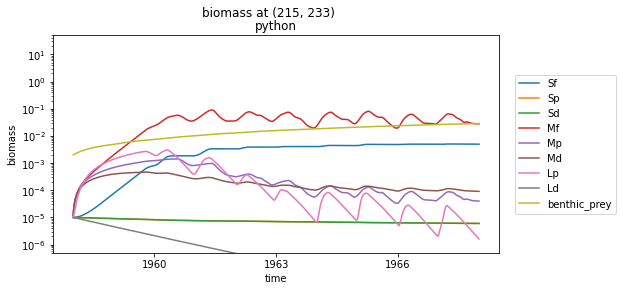

In [9]:
if feisty_config.get('output_in_2D', False):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    for group in da_out2.group.data:
        da_out2.sel(group=group).isel(nlat=nlat, nlon=nlon).plot()
    ax.set_ylim([5e-7, 50])
    ax.set_yscale("log")
    ax.set_title("python")
    plt.legend(da_out2.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
    fig.suptitle(f"biomass at ({nlat}, {nlon})");

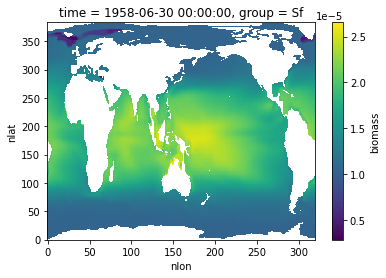

In [10]:
if feisty_config.get('output_in_2D', False):
    da_out2.isel(time=180, group=0).plot()